In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("../data_page1.csv")

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt

# Suprimir advertencias de convergencia de ARIMA, etc.
warnings.filterwarnings("ignore")

# Carga de datos
data = pd.read_csv("../data_page1.csv")

row = {}
for i in data.columns:
    row[i] = []

# Diccionario para almacenar los modelos y sus resultados detallados
#model_results = {}

# Definir los órdenes de ARIMA a probar: (p, d, q)
arima_orders = [
    (1, 1, 0), (0, 1, 1), (1, 1, 1),
    (2, 1, 0), (0, 1, 2), (2, 1, 1)
]

for region in data.región.unique():
    # Inicializar el diccionario de resultados para la región actual
    #model_results[region] = {}
    
    for specie in data.specie.unique():
        # Inicializar el diccionario de resultados para la especie actual
        #model_results[region][specie] = {}
        
        # Selección de región y especie
        df = data[(data.región==region) & (data.specie==specie)].copy()
        df.sort_values("year", inplace=True)
        df.reset_index(inplace=True, drop=True)

        if len(df.year.unique()) != df.shape[0] :
            print(f"Hay años repetidos para {region} - {specie}. Saltando.")
            continue

        features_selec = ["carne", "poblacion", "produccion", "rendimiento"]

        # Modelo ARIMA
        for feat in features_selec:
            Y = df[feat]
            
            best_aic = np.inf
            best_order = None
            best_model_fit = None
            
            # --- Bucle para encontrar el mejor orden ARIMA (p, d, q) ---
            for order in arima_orders:
                try:
                    model = ARIMA(Y, order=order)
                    model_fit = model.fit()

                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = order
                        best_model_fit = model_fit
                except:
                    continue
            
            # --- Almacenamiento del Modelo y Predicción ---
            prediction = np.nan
            
            if best_model_fit is not None:
                prediction = best_model_fit.forecast(steps=1).iloc[-1]
                
                # 1. Almacenar el modelo ajustado
                '''
                model_results[region][specie][feat] = {
                    "model": best_model_fit,
                    "order": best_order,
                    "aic": best_aic,
                    "data": Y.copy(),
                    "prediction": prediction
                }
                '''
                # 2. Generar el gráfico
                
                # Crear la serie de la predicción para graficar
                pred_index = df["year"].max() + 1
                pred_series = pd.Series([prediction], index=[pred_index])
                
                # Crear el índice de tiempo (años) para los datos históricos
                hist_index = df["year"]
                '''
                plt.figure(figsize=(10, 5))
                plt.plot(hist_index, Y, label='Datos Históricos', marker='o')
                plt.plot(pred_series.index, pred_series.values, 
                         label='Predicción ARIMA', marker='*', markersize=10, linestyle='--')
                
                plt.title(f'Predicción ARIMA ({best_order}) para {feat} en {region} ({specie})')
                plt.xlabel('Año')
                plt.ylabel(feat.capitalize())
                plt.legend()
                plt.grid(True)
                plt.show() # Muestra el gráfico
                '''
                #print(f"Región: {region}, Especie: {specie}, Característica: {feat}, Mejor Orden ARIMA: {best_order}, AIC: {best_aic:.2f}, Predicción: {prediction:.2f}")


            # --- Preparación para el DataFrame final ---
            row[feat].append(prediction)


        row["región"].append(region)
        row["year"].append(df.year.max() + 1)
        row["specie"].append(specie)

# Resultado final
result_df = pd.DataFrame(row)


In [3]:
result_df.to_csv("prediction_2025.csv")

# autoregressive model

In [26]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
data = pd.read_csv("../data_page1.csv")


In [8]:
data.head()

,región,year,specie,carne,poblacion,produccion,rendimiento
0,Tumbes,2024,ave,262.910574,183726.0,93692.0,2.806108
1,Piura,2024,ave,31027.129806,3987073.0,13984015.0,2.218757
2,Lambayeque,2024,ave,25241.836631,2510903.0,11388007.0,2.216528
3,La Libertad,2024,ave,305189.102963,25756805.0,138011041.0,2.211338
4,Cajamarca,2024,ave,3438.308384,899534.0,1551093.0,2.216700


In [17]:
df = data[(data.región=="Piura") & (data.specie=="ave")].copy()

In [20]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index("year", inplace=True)

In [24]:
result = adfuller(df["carne"])
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = -1.315, p-value = 0.622


In [38]:
df

,región,specie,carne,poblacion,produccion,rendimiento
year,,,,,,
2024-01-01,Piura,ave,31027.129806,3.987073e+06,1.398402e+07,2.218757
2023-01-01,Piura,ave,30965.581996,3.987073e+06,1.388714e+07,2.229802
2022-01-01,Piura,ave,32372.310000,4.946411e+06,1.466698e+07,2.207156
2021-01-01,Piura,ave,32474.209628,3.905774e+06,1.458162e+07,2.227064
2020-01-01,Piura,ave,32603.805405,5.987048e+06,1.454183e+07,2.242070
2019-01-01,Piura,ave,33053.000000,5.858230e+06,1.478388e+07,2.235747
2018-01-01,Piura,ave,32556.164124,5.987073e+06,1.474598e+07,2.207800
2017-01-01,Piura,ave,28902.432661,6.138251e+06,1.328185e+07,2.176085


In [51]:
df.carne[1:].values-df.carne[:-1].values

array([  -61.54780999,  1406.72800353,   101.89962823,   129.59577628,
         449.19459549,  -496.8358762 , -3653.73146245])

In [25]:
df_diff = df["carne"].diff().dropna()

In [37]:
df_diff

year
2023-01-01     -61.547810
2022-01-01    1406.728004
2021-01-01     101.899628
2020-01-01     129.595776
2019-01-01     449.194595
2018-01-01    -496.835876
2017-01-01   -3653.731462
Name: carne, dtype: float64

In [52]:
result = adfuller(df_diff)
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = 0.069, p-value = 0.964


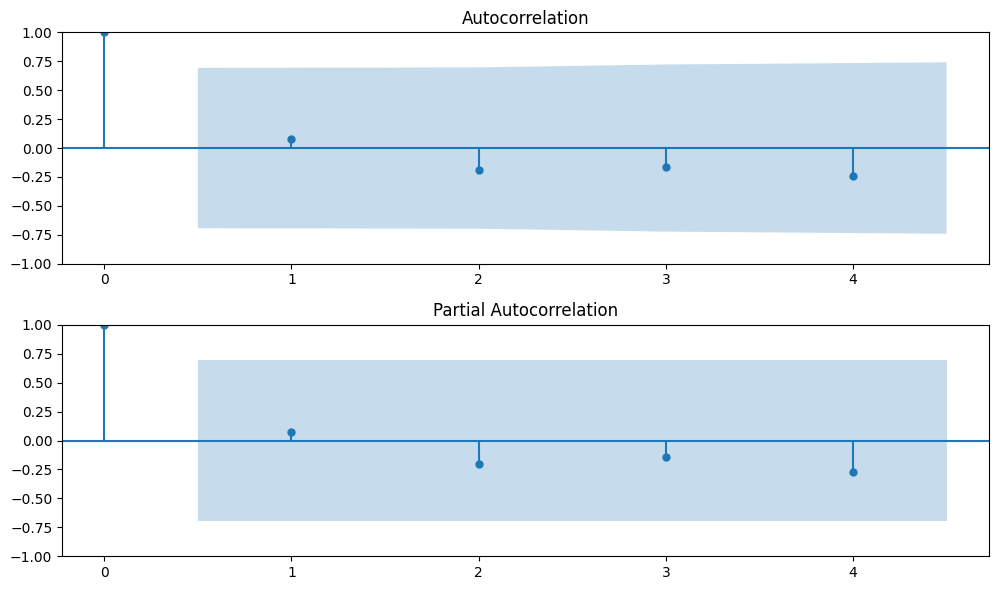

In [60]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df["carne"], lags=4, ax=ax[0])
plot_pacf(df["carne"], lags=4, ax=ax[1])
plt.tight_layout()
plt.show()

In [65]:
df.loc[:,"carne"]

year
2024-01-01    31027.129806
2023-01-01    30965.581996
2022-01-01    32372.310000
2021-01-01    32474.209628
2020-01-01    32603.805405
2019-01-01    33053.000000
2018-01-01    32556.164124
2017-01-01    28902.432661
Name: carne, dtype: float64

In [70]:
p = 3
model = AutoReg(df.loc[:,"carne"], lags=p, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  carne   No. Observations:                    8
Model:                     AutoReg(3)   Log Likelihood                 -41.966
Method:               Conditional MLE   S.D. of innovations           1068.704
Date:                Mon, 08 Dec 2025   AIC                             93.931
Time:                        16:04:28   BIC                             91.979
Sample:                             3   HQIC                            88.690
                                    8                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.521e+04   7.27e+04     -0.622      0.534   -1.88e+05    9.73e+04
carne.L1       4.3506      2.656      1.638      0.101      -0.855       9.556
carne.L2      -0.8606      0.996     -0.864      0.3

/home/angel/Documents/Produccion-Ganadera-Avicola/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
/home/angel/Documents/Produccion-Ganadera-Avicola/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
